In [1]:
'''
    steps
'''
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [3]:
'''
    plots
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
def add_flatten_lists(the_lists):
    result = []
    for _list in the_lists:
        result += _list
    return result

def stats_Hap(df):
    df=df.loc[df.hp!=0,]
    df=df.sort_values(['rid','pos']).reset_index(drop=True)
    statsdf=df.groupby('rid')['pos'].apply(list).reset_index()
    statsdf['hp']=df.groupby('rid')['hp'].apply(list).reset_index()['hp']
    statsdf['fnum']=statsdf['pos'].apply(lambda x: len(x))
    statsdf=statsdf.loc[statsdf.fnum>1,]

    statsdf['isize']=statsdf.pos.apply(lambda x: [abs(i[0]-i[1]) for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.hp.apply(lambda x: [i[0]+i[1] for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.ihp.apply(lambda x: ['h' if i==3 else 'c' for i in x])

    statsdf['fid']=df.groupby('rid')['fid'].apply(list).reset_index()['fid']
    statsdf['adj']=statsdf.fid.apply(lambda x: ['a' if abs(i[0]-i[1])==1 else 'u' for i in list(combinations(x,2)) ])
    
    isize=add_flatten_lists(statsdf.isize)
    ihp=add_flatten_lists(statsdf.ihp)
    adj=add_flatten_lists(statsdf.adj)

    sdf=pd.DataFrame({'isize':isize,'ihp':ihp,'adj':adj})
    return sdf

def cal_htrans(sdf,min_freq=10,binsize=100000,plotx=10**6,lowess_frac=0.05,lowess_it=3):
    sdf['bin_isize']=sdf.isize.apply(lambda x: round(x/binsize)*binsize)
    sdf=sdf.groupby(['bin_isize','ihp'])['isize'].count().reset_index()
    sdf.columns=['bin_isize','interaction','freq']
    sdf=sdf.sort_values(['bin_isize','interaction']).reset_index(drop=True)

    hdf=sdf.groupby('bin_isize')['interaction'].apply(list).reset_index()
    hdf['freq']=sdf.groupby('bin_isize')['freq'].apply(list).reset_index()['freq']
    hdf['total_freq']=hdf.freq.apply(lambda x: sum(x))
    hdf['itype']=hdf.interaction.apply(lambda x: 'b' if len(x)==2 else x[0])
    hdf['hratio']=hdf.apply(lambda x: x.freq[1]/(x.total_freq)*100 if x.itype=='b' else 0 if x.itype=='c' else 100,axis=1)
    hdf['bin_isize']=hdf.bin_isize/plotx
    
    use_bin = (hdf.hratio >= hdf.hratio.loc[0]) & (hdf.hratio <= 30) & (hdf.total_freq >= min_freq)
    hdf=hdf.loc[use_bin].reset_index(drop=True)
    hdf['lowess_hratio'] = lowess(hdf['hratio'],hdf['bin_isize'],frac=lowess_frac,it=lowess_it)[:,1]
    return hdf

In [43]:
Datadir="./figure_processing_data"
chr = 'chr1'
list_dir = f'{Datadir}/Fig4'
fhap_list = list_dir + '/' + chr + '-snp-frag-hap.list'
hic_pair=f'{Datadir}/hic_stats.txt'
out_dir='./pdf'
fhap_list, hic_pair, out_dir

# ## Pore-C Total
fhap=pd.read_csv(fhap_list,header=None,sep='\t',names=['rid','fid','cid','pos', 'mapq', 'hp'])
sdf=stats_Hap(fhap) 
hdf=cal_htrans(sdf,min_freq=10, binsize=500000, lowess_frac=0.1) # 500kb binsize
total_hdf=hdf.copy()

### Pore-C Adjacent
hdf=cal_htrans(sdf.loc[sdf.adj=='a'],min_freq=10, binsize=500000, lowess_frac=0.1 )
adj_hdf=hdf.copy()

### Hi-C
#hic=pd.read_csv(hic_pair,header=None,sep='\t',names=['distance','contact_type','phase_type'])
#phase_hic=hic.loc[hic.phase_type=='p'] ## p: SNP-based, r:pair rescue
sdf=phase_hic[['distance','contact_type']]
sdf.columns=['isize','ihp']
hdf=cal_htrans(sdf, min_freq=10, binsize=500000, lowess_frac=0.1)
hic_hdf=hdf.copy()

In [ ]:
# hthread = 5
# isizelist = []
# for hdf in [total_hdf, adj_hdf, hic_hdf ]:
#     min_herror = (hdf.lowess_hratio - hthread).abs().min()
#     P = (hdf.lowess_hratio - hthread).abs() == min_herror
#     print(hdf.loc[P, :])
#     inx_num = hdf.loc[P,:].index.values[0]
#     print( hdf.loc[inx_num-3:inx_num+3,:] )
#     isizelist.append( hdf.loc[P, "bin_isize"].values[0]  )

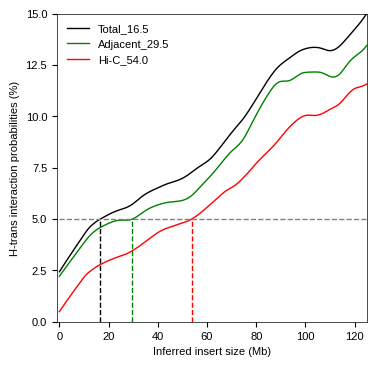

In [50]:
## Fig. 4A: H-trans varies with pairwise distance
### line plot
import numpy as np
plt.figure(figsize = (4,4)) 
[total_v, adj_v, hic_v] =  isizelist # the insert size of 5% h-trans

plt.plot(total_hdf['bin_isize'],total_hdf['lowess_hratio'],color='k')
plt.plot(adj_hdf['bin_isize'],adj_hdf['lowess_hratio'],color='g')
plt.plot(hic_hdf['bin_isize'],hic_hdf['lowess_hratio'],color='r')
plt.legend([f'Total_{total_v}',f'Adjacent_{adj_v}',f'Hi-C_{hic_v}'],frameon=False)
plt.plot([0,130],[5,5],color='grey',linestyle='--',linewidth=1)
plt.plot([hic_v,hic_v],[0,5],color='r',linestyle='--',linewidth=1)
plt.plot([total_v,total_v],[0,5],color='k',linestyle='--',linewidth=1)
plt.plot([adj_v,adj_v],[0,5],color='g',linestyle='--',linewidth=1)

plt.xlim(-1,125)
plt.ylim(0,15)
plt.yticks(np.linspace(0, 15, 7))
plt.xlabel('Inferred insert size (Mb)')
plt.ylabel('H-trans interaction probabilities (%)')

fign=out_dir+'/H-trans_threshold_190X.pdf'
plt.savefig(fign,dpi=300,bbox_inches = 'tight')

In [25]:
Datadir="./figure_processing_data"
chr = 'chr1'
list_dir = f'{Datadir}/Fig4'
hic_pair=f'{Datadir}/hic_stats.txt'

fhap_list = list_dir + '/' + chr + '-snp-frag-hap.list'
#fhap_list = list_dir + '/' "test.list"
dist_file = list_dir + '/' + chr + '-dist-frag-hap.list'
bridge_file = list_dir + '/' + chr + '-bridge-frag-hap.list'
mainHP_file = list_dir + '/' + chr + '-mainHP-frag-hap.list'

In [26]:
fhap=pd.read_csv(fhap_list,header=None,sep='\t',names=['rid','fid','cid','pos', 'mapq', 'hp'])
fhap

,rid,fid,cid,pos,mapq,hp
0,5,0,0,120464776,2,0
1,5,1,0,121112017,1,0
2,5,2,0,120173610,60,0
3,19,0,0,209919417,60,0
4,35,0,0,163801018,30,0
...,...,...,...,...,...,...
49701217,122667008,1,0,53855848,30,0
49701218,122667008,2,0,16425593,30,0
49701219,122667008,5,0,12157778,30,0
49701220,122667008,6,0,52580604,30,0


In [27]:
import multiprocessing

def assign_frag_hp(hp_list):
    hp_num=len(hp_list)
    hp1,hp2,hp0=hp_list.count(1),hp_list.count(2),hp_list.count(0)
    if hp0==hp_num:
        hp=0
    elif hp1==0:
        hp=2
    elif hp2==0:
        hp=1
    else:
        hpr=hp1/hp2
        hp=1 if hpr>=2 else 2 if hpr<=0.5 else 0
    return hp

def rescue_by_dist(df,adj_dist,total_dist):
    pdf=df.loc[df.hp!=0]
    udf=df.loc[df.hp==0]
    udf.columns=['rid','fid0','cid0','pos0', 'mapq0', 'hp0']
    
    edf=pd.merge(udf,pdf)
    edf['extend']=edf.apply(lambda x: abs(x.pos-x.pos0)<=adj_dist if abs(x.fid-x.fid0)==1 else abs(x.pos-x.pos0)<=total_dist,axis=1)
    edf['hp']=edf.apply(lambda x: x.hp if x.extend else 0,axis=1)
    edf=edf.groupby('fid0')['hp'].apply(list).reset_index()
    edf['hp']=edf.hp.apply(lambda x: assign_frag_hp(x))
    pdf['by_dist']=pdf.hp
    edf=pd.merge(udf,edf)
    return pdf,edf

def rescue_by_bridge(df):
    df['by_bridge']=df['by_dist']
    df=df.sort_values('fid').reset_index(drop=True)
    hpl=df.by_dist.to_list()
    fidl=df.fid.to_list()
    # find bridge
    hfidl=[f for h,f in zip(hpl,fidl) if h!=0]
    hbridge=[[hfidl[i],hfidl[i+1]] for i in range(len(hfidl)-1) if hfidl[i+1]-hfidl[i]!=1]
    # find close bridge: contiguous and same hp
    for hb in hbridge:
        s,e=hb[0],hb[-1]
        bdf=df.loc[(df.fid>=s)&(df.fid<=e),]
        continuous=(len(bdf)==e-s+1)
        shp,ehp=bdf.iloc[0]['by_dist'],bdf.iloc[-1]['by_dist']
        same_hp=(shp==ehp)
        if continuous and same_hp:
            df.loc[(df.fid>=s)&(df.fid<=e),'by_bridge']=shp
    return df

def rescue_by_mainHP(df):
    df['by_mainHP']=df['by_bridge']
    hp_list=df.by_bridge.to_list()
    h1_count,h2_count,fnum=hp_list.count(1),hp_list.count(2),len(hp_list)
    h1_ratio=h1_count/fnum*100
    h2_ratio=h2_count/fnum*100
    if h1_ratio>=80 or h2_count==0: ## main HP1 or HP1-only
        df.loc[df.by_bridge==0,'by_mainHP']=1
    elif h2_ratio>=80 or h1_count==0: ## main HP2 or HP2-only
        df.loc[df.by_bridge==0,'by_mainHP']=2
    return df


def processfun(sfhap):
    adj_dist,total_dist=29500000,16500000
    rlist = []
    blist = []
    mlist = []
    for r, rdf in sfhap.groupby('rid'):
        ## by_dist
        unphase=rdf.hp.to_list().count(0)
        if unphase == 0 or unphase == len(rdf):
            rdf['by_dist'] = rdf.hp  # dist
            rdf['by_bridge']=rdf.by_dist #  bridge
            rdf['by_mainHP']=rdf.by_bridge # mainHP
        else:
            pdf, edf = rescue_by_dist(rdf, adj_dist, total_dist)
            pdf.columns = ['rid','fid','cid','pos', 'mapq', 'hp', 'by_dist']
            edf.columns = ['rid','fid','cid','pos', 'mapq', 'hp', 'by_dist']
            rdf = pd.concat([pdf, edf])
            
            ### bridge
            rdf=rescue_by_bridge(rdf)
            ### mainHP run
            rdf=rescue_by_mainHP(rdf)
        rdf.columns = ['rid','fid','cid','pos', 'mapq', 'hp','by_dist','by_bridge', 'by_mainHP']
        rlist.append(rdf)
    rdfs = pd.concat(rlist) # merge
    rlist = None
    return rdfs

def split(lst, N):
    lst_len = len(lst)
    step = lst_len // N
    for i in range(0, lst_len, step):
        yield lst[i:i + step]

def Parrallerun(pfhap, dist_file, bridge_file, mainHP_file):
    pool = multiprocessing.Pool(20) 
    results = []
    readlist = list( pfhap["rid"].unique() )
    N = 200
    if len(readlist) <= N:
        N = 1
    for part in split(readlist, N):
        sfhap = pfhap.loc[pfhap.rid.isin(part), :].reset_index(drop=True)
        result = pool.apply_async(processfun, (sfhap,))
        results.append(result)

    rlist = [ r.get() for r in results ]  
    pool.close()
    pool.join()
    results = None
    
    RDF = pd.concat(rlist)
    CIDs = ['rid','fid','cid','pos', 'mapq', 'hp','by_dist','by_bridge', 'by_mainHP']
    RDF.loc[:, CIDs[:7]].to_csv(dist_file, sep = "\t", header=False, index = False, mode="a")
    RDF.loc[:, CIDs[:8]].to_csv(bridge_file, sep = "\t", header=False, index = False, mode="a")
    RDF.loc[:, CIDs].to_csv(mainHP_file, sep = "\t", header=False, index = False, mode="a")
    rflist = None
    RDF = None
    
# Runs
readlist = list( fhap["rid"].unique() )
N = 100
steps = 0
for exfile in  [dist_file, bridge_file, mainHP_file] :
    with open(exfile, "w") as fileID:
        fileID.flush()
    fileID.close()

for part in split(readlist, N):
    pfhap = fhap.loc[ fhap.rid.isin(part), :].reset_index(drop=True)
    Parrallerun(pfhap, dist_file, bridge_file, mainHP_file) # Parallele run
    steps += 1
    print(f"{steps} : {len(part)} reads finished!")

1 : 149624 reads finished!
2 : 149624 reads finished!
3 : 149624 reads finished!
4 : 149624 reads finished!
5 : 149624 reads finished!
6 : 149624 reads finished!
7 : 149624 reads finished!
8 : 149624 reads finished!
9 : 149624 reads finished!
10 : 149624 reads finished!
11 : 149624 reads finished!
12 : 149624 reads finished!
13 : 149624 reads finished!
14 : 149624 reads finished!
15 : 149624 reads finished!
16 : 149624 reads finished!
17 : 149624 reads finished!
18 : 149624 reads finished!
19 : 149624 reads finished!
20 : 149624 reads finished!
21 : 149624 reads finished!
22 : 149624 reads finished!
23 : 149624 reads finished!
24 : 149624 reads finished!
25 : 149624 reads finished!
26 : 149624 reads finished!
27 : 149624 reads finished!
28 : 149624 reads finished!
29 : 149624 reads finished!
30 : 149624 reads finished!
31 : 149624 reads finished!
32 : 149624 reads finished!
33 : 149624 reads finished!
34 : 149624 reads finished!
35 : 149624 reads finished!
36 : 149624 reads finished!
3

In [28]:
fhap

,rid,fid,cid,pos,mapq,hp
0,5,0,0,120464776,2,0
1,5,1,0,121112017,1,0
2,5,2,0,120173610,60,0
3,19,0,0,209919417,60,0
4,35,0,0,163801018,30,0
...,...,...,...,...,...,...
49701217,122667008,1,0,53855848,30,0
49701218,122667008,2,0,16425593,30,0
49701219,122667008,5,0,12157778,30,0
49701220,122667008,6,0,52580604,30,0


In [29]:
rdf=fhap.groupby('rid')['hp'].apply(list).reset_index()
rdf['fnum']=rdf.hp.apply(lambda x: len(x))
rdf['rtype']=rdf.hp.apply(lambda x: 'un' if x.count(0)==len(x) else 'com' if x.count(0)==0 else 'incom')
rdf

,rid,hp,fnum,rtype
0,5,"[0, 0, 0]",3,un
1,19,[0],1,un
2,35,"[0, 0, 0]",3,un
3,37,"[0, 0]",2,un
4,44,[0],1,un
...,...,...,...,...
14962396,122666976,"[1, 0, 0]",3,incom
14962397,122666984,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12,un
14962398,122666993,[0],1,un
14962399,122666998,[0],1,un


In [30]:
pdf=rdf.loc[rdf.rtype!='un']
pdf['htype']=pdf.hp.apply(lambda x: 'H-trans' if x.count(1)>0 and x.count(2)>0 else 'Cis')
pdf

,rid,hp,fnum,rtype,htype
5,46,"[0, 0, 0, 0, 1]",5,incom,Cis
6,69,"[0, 0, 0, 0, 0, 2, 0, 0]",8,incom,Cis
9,74,"[1, 1]",2,com,Cis
10,81,"[0, 2, 0, 2]",4,incom,Cis
14,143,"[1, 0]",2,incom,Cis
...,...,...,...,...,...
14962389,122666915,"[1, 1, 0]",3,incom,Cis
14962391,122666928,"[0, 1, 0, 0, 0]",5,incom,Cis
14962392,122666942,"[0, 2, 0]",3,incom,Cis
14962394,122666973,"[1, 0, 0, 0]",4,incom,Cis


In [31]:
pdf=pdf.groupby(['fnum','htype'])['rid'].count().reset_index()
pdf=pdf.sort_values(['fnum','htype']).reset_index(drop=True)
pdf

,fnum,htype,rid
0,1,Cis,907142
1,2,Cis,932360
2,2,H-trans,5059
3,3,Cis,924511
4,3,H-trans,8412
...,...,...,...
105,58,Cis,2
106,59,Cis,1
107,61,Cis,1
108,63,Cis,1


In [32]:
hdf=pdf.groupby('fnum')['htype'].apply(list).reset_index()
hdf['counts']=pdf.groupby('fnum')['rid'].apply(list).reset_index()['rid']
hdf['ctype']=hdf.htype.apply(lambda x: 'both' if len(x)==2 else  x[0])
hdf['hratio']=hdf.apply(lambda x: 0 if x.ctype=='Cis' else 100 if x.ctype=='H-trans' else x.counts[1]/sum(x.counts)*100,axis=1)
hdf['cratio']=hdf.apply(lambda x: 100 if x.ctype=='Cis' else 0 if x.ctype=='H-trans' else x.counts[0]/sum(x.counts)*100,axis=1)
hdf

,fnum,htype,counts,ctype,hratio,cratio
0,1,[Cis],[907142],Cis,0.000000,100.000000
1,2,"[Cis, H-trans]","[932360, 5059]",both,0.539673,99.460327
2,3,"[Cis, H-trans]","[924511, 8412]",both,0.901682,99.098318
3,4,"[Cis, H-trans]","[836791, 10563]",both,1.246586,98.753414
4,5,"[Cis, H-trans]","[698475, 11294]",both,1.591222,98.408778
...,...,...,...,...,...,...
56,58,[Cis],[2],Cis,0.000000,100.000000
57,59,[Cis],[1],Cis,0.000000,100.000000
58,61,[Cis],[1],Cis,0.000000,100.000000
59,63,[Cis],[1],Cis,0.000000,100.000000


In [33]:
fnum=hdf.loc[hdf.fnum<=20,'fnum'].to_list()
hratio=hdf.loc[hdf.fnum<=20,'hratio'].to_list()

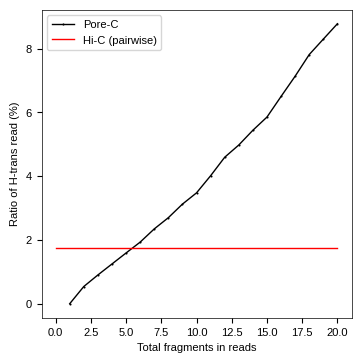

In [34]:
## Fig. 4B
plt.figure(figsize=(4,4))

plt.plot(fnum,hratio,color='k',marker='.',label='Pore-C')
plt.plot([0,20],[1.75,1.75],color='r',label='Hi-C (pairwise)')
plt.legend()
plt.xlabel('Total fragments in reads')
plt.ylabel('Ratio of H-trans read (%)')

fig=out_dir+'/mutiway_htrans.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [35]:
mdf=rdf.loc[(rdf.rtype=='com')&(rdf.fnum>=3),]
mdf['HP1_ratio']=mdf.hp.apply(lambda x: round(x.count(1)/len(x)*100,2))
mdf

,rid,hp,fnum,rtype,HP1_ratio
587,5044,"[1, 1, 1]",3,com,100.0
935,8075,"[2, 2, 2, 2]",4,com,0.0
938,8098,"[2, 2, 2]",3,com,0.0
1863,15538,"[1, 1, 1]",3,com,100.0
1952,16332,"[1, 1, 1]",3,com,100.0
...,...,...,...,...,...
14958672,122638400,"[2, 2, 2]",3,com,0.0
14960441,122651282,"[1, 1, 1]",3,com,100.0
14961154,122656847,"[1, 1, 1, 1]",4,com,100.0
14961548,122660385,"[1, 1, 1]",3,com,100.0


In [36]:
mdf=mdf.groupby('HP1_ratio')['rid'].count().reset_index()
mdf['ratio']=mdf.rid/sum(mdf.rid)*100
mdf

,HP1_ratio,rid,ratio
0,0.00,29536,48.563771
1,12.50,3,0.004933
2,14.29,1,0.001644
3,16.67,11,0.018086
4,20.00,53,0.087144
5,25.00,185,0.304181
6,33.33,737,1.211792
7,40.00,7,0.011510
8,50.00,62,0.101942
9,60.00,10,0.016442


In [37]:
HP1_label='HP1-only\n'+str(round(mdf.ratio.iloc[-1],2))+'%'
HP2_label='HP2-only\n'+str(round(mdf.ratio.iloc[0],2))+'%'
HT_label='H-trans\n'+str(round(100-mdf.ratio.iloc[-1]-mdf.ratio.iloc[0],2))+'%'

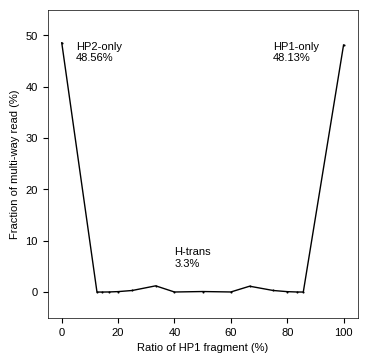

In [38]:
## Fig. 4C
plt.figure(figsize=(4,4))
plt.plot(mdf.HP1_ratio,mdf.ratio,marker='.',color='k')
plt.text(5,45,HP2_label)
plt.text(75,45,HP1_label)
plt.text(40,5,HT_label)

plt.xlabel('Ratio of HP1 fragment (%)')
plt.ylabel('Fraction of multi-way read (%)')
plt.ylim(-5,55)
#plt.title('Phasing completeness')

fig=out_dir+'/mainhp.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [41]:
fhap_list = list_dir + '/' + chr + '-snp-frag-hap.list'
dist_file = list_dir + '/' + chr + '-dist-frag-hap.list'
bridge_file = list_dir + '/' + chr + '-bridge-frag-hap.list'
mainHP_file = list_dir + '/' + chr + '-mainHP-frag-hap.list'

fhap=pd.read_csv(fhap_list,header=None,sep='\t',names=['rid','fid','cid','pos','mapq','hp'])
dist=pd.read_csv(mainHP_file,header=None,sep='\t', usecols=[0,1,2,3,4,6],
                 names=['rid','fid','cid','pos','mapq','hp'])
bridge=pd.read_csv(mainHP_file,header=None,sep='\t', usecols=[0,1,2,3,4,7],
                   names=['rid','fid','cid','pos','mapq','hp'])
mainHP=pd.read_csv(mainHP_file,header=None,sep='\t', usecols=[0,1,2,3,4,8],
                   names=['rid','fid','cid','pos','mapq','hp'])

[10422327, 27234694, 27997237, 30058313]
[20.97, 54.8, 56.33, 60.48]


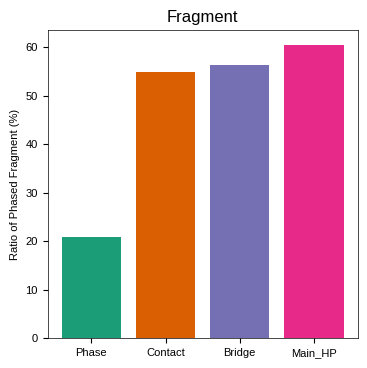

In [42]:
## Fig. 4H: Fragment rescue stats
fn=len(fhap)
pfn=sum(fhap.hp!=0)
dfn=sum(dist.hp!=0)
bfn=sum(bridge.hp!=0)
mfn=sum(mainHP.hp!=0)

fn_list=[pfn,dfn,bfn,mfn]
fn_ratio=[round(n/fn*100,2) for n in fn_list]

### bar plot
plt.figure(figsize=(4,4))
use_col=plt.get_cmap('Dark2')(range(0,6,1))
plt.bar(['Phase','Contact','Bridge','Main_HP'],fn_ratio,width=0.8,color=use_col)

plt.ylabel('Ratio of Phased Fragment (%)')
plt.title('Fragment')

fig=out_dir+'/Rescue_step_fragment.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

print(fn_list)
print(fn_ratio)

[6609067, 77291914, 82826386, 93646128]
[5.36, 62.69, 67.18, 75.95]


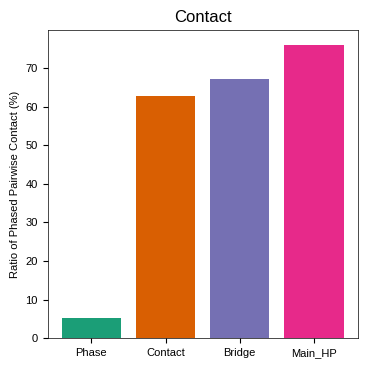

In [43]:
## Fig. 4I: Contact rescue stats
cal_pn=pd.DataFrame({'fnum':list(range(1,100))})
cal_pn['pnum']=cal_pn.fnum.apply(lambda x: len(list(combinations(range(x),2))))
cal_pn

def cal_pwise_count(df):
    pn=df.groupby('rid')['fid'].count().value_counts().rename_axis('fnum').reset_index(name='counts')
    pn=pd.merge(pn,cal_pn)
    return sum(pn.counts*pn.pnum)

pn=cal_pwise_count(fhap)
ppn=cal_pwise_count(fhap.loc[fhap.hp!=0,])
dpn=cal_pwise_count(dist.loc[dist.hp!=0,])
bpn=cal_pwise_count(bridge.loc[bridge.hp!=0,])
mpn=cal_pwise_count(mainHP.loc[mainHP.hp!=0,])

pn_list=[ppn,dpn,bpn,mpn]
pn_ratio=[round(n/pn*100,2) for n in pn_list]

### bar plot
plt.figure(figsize=(4,4))

use_col=plt.get_cmap('Dark2')(range(0,6,1))
plt.bar(['Phase','Contact','Bridge','Main_HP'],pn_ratio,width=0.8,color=use_col)

plt.ylabel('Ratio of Phased Pairwise Contact (%)')
plt.title('Contact')

fig=out_dir+'/Rescue_step_contact.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

print(pn_list)
print(pn_ratio)

   Complete  Incomplete  Unphased
0   1146282     5233622   8582497
1   4969961     1409943   8582497
2   5299946     1079958   8582497
3   6336434       43470   8582497
    Complete  Incomplete   Unphased
0   7.661083   34.978490  57.360426
1  33.216333    9.423240  57.360426
2  35.421762    7.217812  57.360426
3  42.349045    0.290528  57.360426


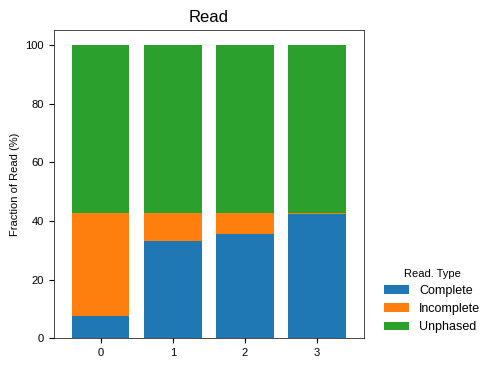

In [44]:
## Fig. 4J: Read rescue stats
def stats_read(fhap):
    rhap=fhap.groupby('rid')['hp'].apply(list).reset_index()
    rnum_list=rhap['hp'].apply(lambda x: 'un' if x.count(0)==len(x) else 'com' if x.count(0)==0 else 'incom').value_counts()
    rnum_list=[rnum_list['com'],rnum_list['incom'],rnum_list['un']]
    return rnum_list

fhap_rlist=stats_read(fhap)
dist_rilst=stats_read(dist)
bridge_rlist=stats_read(bridge)
mainHP_rlist=stats_read(mainHP)

rdf=pd.DataFrame([fhap_rlist,dist_rilst,bridge_rlist,mainHP_rlist],columns=['Complete','Incomplete','Unphased'])
print(rdf)
rn=sum(fhap_rlist)
rdf=rdf/rn*100

### bar plot
snp_plot = rdf.plot(kind='bar',stacked=True,figsize=(4,4),rot=0,width=0.8)#,fontsize=12
snp_plot.set_ylabel('Fraction of Read (%)')#,fontsize=12

snp_plot.legend(title='Read. Type',prop = {'size':9},frameon=False,bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
snp_plot.set_title('Read')

fig=out_dir+'/Rescue_step_read.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

print(rdf)